# AWS Forecast using DeepAR Plus

The overall process for using Amazon Forecast is the following:

1. Get Data set 
1. Create a Dataset Group.
1. Create a Dataset, in Forecast there are 3 types of dataset, Target Time Series, Related Time Series, and Item Metadata
1. Import data into Forecast from AWS Storage S3
1. Train a model
1. Create a Predictor
1. Query the Forecast
1. Referenced from Amazon Forecast Samples at https://github.com/aws-samples/amazon-forecast-samples

In [152]:
import sys
import os
import json
import time
import pandas as pd
import boto3
import numpy as np
from cloudmesh.common.StopWatch import StopWatch
from time import sleep

### Data Load 
* Load into a dataframe from .csv file.
* Functions to set less than 0 values to 0
* Set missing values to 0
* Create a log scale for the value

In [153]:
df = pd.read_csv("data.csv", dtype = object, names=['timestamp','value','item_id'], skiprows=1)
df.value=df.value.astype(float)
df.head(3)

,timestamp,value,item_id
0,NaN,-12.000000,NaN
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2


In [154]:
def updatedf(x,setval):
    if x < 0 :
        x=setval
    return x

def updateNan(x):
    return x.fillna(0)

In [155]:
df['value'] = df['value'].apply(lambda x: updatedf(x,0))
df.head()

,timestamp,value,item_id
0,NaN,0.000000,NaN
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [156]:
df = df.apply(lambda x: updateNan(x))
df.head()

,timestamp,value,item_id
0,0,0.000000,0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [157]:
import matplotlib.pyplot as plt 

Text(0.5, 0.98, 'Log Scale for Value column in the dataframe')

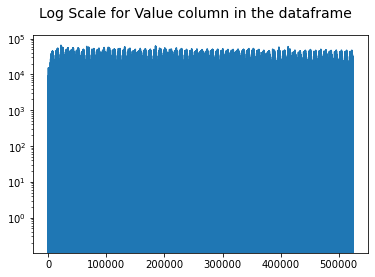

In [158]:
fig=plt.figure()
plt.yscale("log")
plt.plot(df['value']) 
fig.suptitle('Log Scale for Value column in the dataframe', fontsize=14)

### Split the data set into training and test.

In [159]:
def split_data_train_test(data,percentage=0.3):
    from sklearn.model_selection import train_test_split
    x_train ,x_test = train_test_split(data,test_size=percentage)
    return x_train, x_test

In [160]:
#divide the data into Train and Test Dataset.
split_percentage=0.3
train_df, test_df= split_data_train_test(df,split_percentage)

In [161]:
StopWatch.start('to_csv')

train_df.to_csv("aiservices-train.csv", header=False, index=False)
test_df.to_csv("aiservices-test.csv", header=False, index=False)

StopWatch.stop('to_csv')

print (StopWatch.get('to_csv'))

4


### Initialize required cloud services

In [162]:
region='us-east-1'
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

In [163]:
import botocore

key="aiservices-train.csv"
bucket_name='awsforecastassignnment'

StopWatch.start('to_s3')

boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("aiservices-train.csv")


StopWatch.stop('to_s3')

print (StopWatch.get('to_s3'))

9


## Creating the Dataset Group and Dataset <a class="anchor" id="dataset"></a>

A dataset is a collection of file(s) having relevant data for forecasting task. A dataset must conform to a schema provided by Amazon Forecast. 

In [164]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

In [165]:
project = 'timeseries_1'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+key

### Create the Dataset Group

In [166]:
StopWatch.start('to_dsg')

try:
    create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName, Domain="CUSTOM",)
    datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "ResourceAlreadyExistsException":
        response = forecast.list_dataset_groups(MaxResults=2)
        datasetGroupArn = response['DatasetGroupArn']
        print(response)
        # The dataset already exists no need to re-create
        print("\nThe dataset group already exists")
    elif e.response['Error']['Code'] == "ResourceInUseException":
        # The dataset already exists no need to re-create
        print("The requested dataset group is in use")

StopWatch.stop('to_dsg')

print (StopWatch.get('to_dsg'))

0


In [167]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'timeseries_1_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:514439120157:dataset-group/timeseries_1_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 2, 17, 18, 51, 347000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 2, 17, 18, 51, 347000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '7a7520ef-a652-40ad-9a70-f2e867602740',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:19:19 GMT',
   'x-amzn-requestid': '7a7520ef-a652-40ad-9a70-f2e867602740',
   'content-length': '255',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create the Schema

In [168]:
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

### Create the Dataset

In [169]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [170]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:514439120157:dataset/timeseries_1_ds',
 'DatasetName': 'timeseries_1_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5, 2, 17, 19, 28, 849000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 5, 2, 17, 19, 28, 849000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '7a4beb1b-fb8e-424b-a010-679750537fe7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:19:37 GMT',
   'x-amzn-requestid': '7a4beb1b-fb8e-424b-a010-679750537fe7',
   'content-length': '491',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Add Dataset to Dataset Group

In [171]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '775e7f4f-3c68-4a04-8981-7c1d6ef18600',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:19:44 GMT',
   'x-amzn-requestid': '775e7f4f-3c68-4a04-8981-7c1d6ef18600',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create IAM Role for Forecast

Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to ["notebooks/common/util/fcst_utils.py"](../../common/util/fcst_utils.py) for implementation.

In [172]:
# Create the role to provide to Amazon Forecast.
role_arn = 'arn:aws:iam::1232432:role/abcbcbc'

### Create Data Import Job


Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecaast.

In [173]:
datasetImportJobName = project +'_IMPORT_JOB'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [174]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:514439120157:dataset-import-job/timeseries_1_ds/timeseries_1_IMPORT_JOB


In [175]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'timeseries_1_IMPORT_JOB',
 'DatasetImportJobArn': 'arn:aws:forecast:us-east-1:514439120157:dataset-import-job/timeseries_1_ds/timeseries_1_IMPORT_JOB',
 'DatasetArn': 'arn:aws:forecast:us-east-1:514439120157:dataset/timeseries_1_ds',
 'TimestampFormat': 'yyyy-MM-dd hh:mm:ss',
 'DataSource': {'S3Config': {'Path': 's3://awsforecastassignnment/aiservices-train.csv',
   'RoleArn': 'arn:aws:iam::514439120157:role/ForecastRolePP'}},
 'FieldStatistics': {'item_id': {'Count': 366744,
   'CountDistinct': 370,
   'CountNull': 0},
  'target_value': {'Count': 366744,
   'CountDistinct': 246173,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0.0',
   'Max': '65150.0',
   'Avg': 522.4259184939198,
   'Stddev': 2348.673213771905},
  'timestamp': {'Count': 366744,
   'CountDistinct': 1416,
   'CountNull': 0,
   'Min': '2014-01-01T01:00:00Z',
   'Max': '2014-03-01T00:00:00Z'}},
 'DataSize': 0.016815279610455036,
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 5,

In [176]:
predictorName= project+'_deeparp_algo'

In [177]:
forecastHorizon = 24

In [178]:
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

In [179]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  AlgorithmArn=algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": 24}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "D", 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

In [180]:
predictor_arn=create_predictor_response['PredictorArn']

In [181]:
forecast.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 1026.261317660324,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17743858522649836},
       {'Quantile': 0.5, 'LossValue': 0.546224869157166},
       {'Quantile': 0.1, 'LossValue': 0.2747187786840493}]}},
    {'TestWindowStart': datetime.datetime(2014, 2, 27, 20, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2014, 2, 28, 20, 0, tzinfo=tzlocal()),
     'ItemCount': 370,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 1026.2613176603243,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17743858522649825},
       {'Quantile': 0.5, 'LossValue': 0.5462248691571657},
       {'Quantile': 0.1, 'LossValue': 0.2747187786840492}]}}]}],
 'ResponseMetadata': {'RequestId': '478d3293-2a38-4a30-b35a-f6a09ca1ec62',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {

In [182]:
forecastName= project+'_deeparp_algo_forecast'

In [183]:
create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictor_arn)
forecast_arn = create_forecast_response['ForecastArn']

In [184]:
print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":"client_37"}
)
print(forecastResponse)

arn:aws:forecast:us-east-1:514439120157:forecast/timeseries_1_deeparp_algo_forecast

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2014-03-01T01:00:00', 'Value': 2.0108985900878906}, {'Timestamp': '2014-03-01T02:00:00', 'Value': 22.140838623046875}, {'Timestamp': '2014-03-01T03:00:00', 'Value': 12.109325408935547}, {'Timestamp': '2014-03-01T04:00:00', 'Value': 6.897163391113281}, {'Timestamp': '2014-03-01T05:00:00', 'Value': 17.944034576416016}, {'Timestamp': '2014-03-01T06:00:00', 'Value': 24.617610931396484}, {'Timestamp': '2014-03-01T07:00:00', 'Value': 27.04290008544922}, {'Timestamp': '2014-03-01T08:00:00', 'Value': 21.201675415039062}, {'Timestamp': '2014-03-01T09:00:00', 'Value': 16.764511108398438}, {'Timestamp': '2014-03-01T10:00:00', 'Value': 8.969970703125}, {'Timestamp': '2014-03-01T11:00:00', 'Value': 2.1800308227539062}, {'Timestamp': '2014-03-01T12:00:00', 'Value': 27.081893920898438}, {'Timestamp': '2014-03-01T13:00:00', 'Value': 19.833778381347656}, {'Timestamp'

In [235]:
actual_df_new = pd.read_csv("aiservices-test.csv", names=['timestamp','value','item_id'])
actual_df_new.head()

,timestamp,value,item_id
0,2014-01-12 11:00:00,40.290433,client_15
1,2014-02-03 02:00:00,538.632353,client_297
2,2014-02-12 20:00:00,3093.881857,client_362
3,2014-01-14 09:00:00,11.643119,client_47
4,2014-02-23 05:00:00,41.696137,client_314


In [243]:
actual_df_new = actual_df_new[(actual_df_new['timestamp'] >= '2014-01-01') & (actual_df_new['timestamp'] < '2015-03-02')]

In [244]:
actual_df_new = actual_df_new[(actual_df_new['item_id'] == 'client_37')]


In [245]:
actual_df_new.head()

,timestamp,value,item_id
364,2014-01-04 05:00:00,95.876963,client_37
1077,2014-02-22 01:00:00,90.968586,client_37
1145,2014-01-23 13:00:00,166.230366,client_37
1250,2014-01-14 19:00:00,163.612565,client_37
1401,2014-01-02 07:00:00,108.311518,client_37


In [246]:
pred_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
pred_df_p10.head()

,Timestamp,Value
0,2014-03-01T01:00:00,2.010899
1,2014-03-01T02:00:00,22.140839
2,2014-03-01T03:00:00,12.109325
3,2014-03-01T04:00:00,6.897163
4,2014-03-01T05:00:00,17.944035


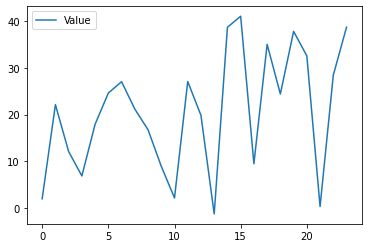

In [247]:
pred_df_p10.plot()

In [248]:
pred_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
pred_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

In [249]:
results_df_new = pd.DataFrame(columns=['timestamp', 'value', 'source'])

In [250]:
import dateutil.parser
for index, row in actual_df_new.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df_new  = results_df_new.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)

In [251]:
results_df_new.head()

,timestamp,value,source
0,2014-01-04 05:00:00,95.876963,actual
1,2014-02-22 01:00:00,90.968586,actual
2,2014-01-23 13:00:00,166.230366,actual
3,2014-01-14 19:00:00,163.612565,actual
4,2014-01-02 07:00:00,108.311518,actual


In [252]:
# Now add the P10, P50, and P90 Values
for index, row in pred_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df_new.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in pred_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df_new.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in pred_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df_new.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [253]:
pivot_df_new = results_df_new.pivot(columns='source', values='value', index="timestamp")

pivot_df_new

source,actual
timestamp,
2014-01-01 05:00:00,85.078534
2014-01-01 14:00:00,103.403141
2014-01-01 15:00:00,95.876963
2014-01-01 16:00:00,99.149215
2014-01-01 23:00:00,136.780105
...,...
2014-02-28 18:00:00,153.795812
2014-02-28 19:00:00,156.086387
2014-02-28 21:00:00,147.905759


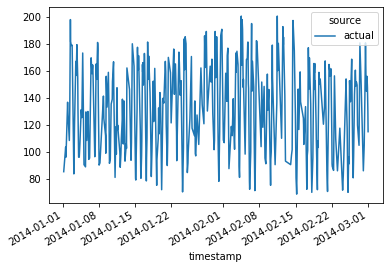

In [254]:
pivot_df_new.plot()

In [255]:
forecast.delete_forecast(ForecastArn=forecast_arn)

{'ResponseMetadata': {'RequestId': 'ce44c2dc-fe98-45c4-a413-2e366f785d3f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 22:42:40 GMT',
   'x-amzn-requestid': 'ce44c2dc-fe98-45c4-a413-2e366f785d3f',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [144]:
forecast.delete_predictor(PredictorArn=predictor_arn)

{'ResponseMetadata': {'RequestId': '83fb629c-d9b5-4a85-91f9-2fd7f7a4fa66',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:16:29 GMT',
   'x-amzn-requestid': '83fb629c-d9b5-4a85-91f9-2fd7f7a4fa66',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [146]:
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'ResponseMetadata': {'RequestId': 'bdfbdb9e-a6cc-4e7d-b4ab-fef0a2761124',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:16:56 GMT',
   'x-amzn-requestid': 'bdfbdb9e-a6cc-4e7d-b4ab-fef0a2761124',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [149]:
forecast.delete_dataset(DatasetArn=datasetArn)

{'ResponseMetadata': {'RequestId': '38f5de29-759a-46ec-89dd-11e82d9dbaa1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:17:10 GMT',
   'x-amzn-requestid': '38f5de29-759a-46ec-89dd-11e82d9dbaa1',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [150]:
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)

{'ResponseMetadata': {'RequestId': 'e0db8ab6-99a7-49db-9293-d8f6736f8339',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 02 May 2020 21:17:16 GMT',
   'x-amzn-requestid': 'e0db8ab6-99a7-49db-9293-d8f6736f8339',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [151]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).delete()

{'ResponseMetadata': {'RequestId': 'BFD0B30DA63731A5',
  'HostId': 'M/Yb/mmYuVd87G+CbJnlqmUwt1L+jatbovH+zPHZJl5B4N7MJquv+CizlqtmWiWcUYtmXaCxiIg=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'M/Yb/mmYuVd87G+CbJnlqmUwt1L+jatbovH+zPHZJl5B4N7MJquv+CizlqtmWiWcUYtmXaCxiIg=',
   'x-amz-request-id': 'BFD0B30DA63731A5',
   'date': 'Sat, 02 May 2020 21:17:25 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 1}}